In [4]:
#Libraries/functions import

from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10
import pyproj
import matplotlib.image as image
from lxml import etree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from itertools import chain
from matplotlib import colors
import datetime
from pandas.io.json import json_normalize
import requests
import facebook
import matplotlib.ticker as plticker
from tabulate import tabulate
import credentials

# Convenience functions for working with colour ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

In [5]:
#Dates used in file names, maps etc.
current_time = datetime.datetime.now().strftime("%d-%m-%Y %H:%M")
the_day = datetime.date.today() + datetime.timedelta(days=-1)
date_to_print = the_day.strftime("%d-%m-%Y")
date_to_file = the_day.strftime("%d%m%y")
current_time_to_file = datetime.datetime.now().strftime("%Y%m%d%H%M")

In [6]:
headers = {
    'Accept': 'application/json',
    'apikey': credentials.airly,
}

params = (
    ('lat', '50.1'),
    ('lng', '18.5'),
    ('maxDistanceKM', '15'),
    ('maxResults', '50'))

response = requests.get('https://airapi.airly.eu/v2/installations/nearest', headers=headers, params=params)

In [7]:
#transform response to json
data_js = response.json()

df_temp = pd.DataFrame.from_records(data_js)

df_temp1 = df_temp['sponsor'].apply(pd.Series).drop(['id'], axis=1)
df_temp2 = df_temp['address'].apply(pd.Series)
df_temp3 = df_temp['location'].apply(pd.Series)

df_temp_all = pd.concat([df_temp, df_temp1, df_temp2, df_temp3], axis=1).query('name=="Rybnik" and airly==True')

sensors = df_temp_all[['id','displayAddress1','displayAddress2','latitude','longitude']].set_index('id')

In [8]:
sensors

,displayAddress1,displayAddress2,latitude,longitude
id,,,,
2250,"Rybnik, Zebrzydowice","ZSP 12, M. Buhla 3",50.101856,18.492540
2091,"Rybnik, Maroko-Nowiny","ZS 3, Orzepowicka 15a",50.100010,18.517342
2331,"Rybnik, Orzepowice","ZSP 7, Borki 37D",50.110970,18.516068
2094,"Rybnik, Smolna","SP 34, W. Reymonta 69",50.090576,18.526136
3516,Rybnik,Wodzisławska,50.081203,18.526903
2329,"Rybnik, Niedobczyce","SP 21, Niedobczycka 191",50.070332,18.501020
6561,"Rybnik, Rybnicka Kuźnia","ZSP 13, Św. Maksymiliana 26",50.124737,18.525684
2107,"Rybnik, Śródmieście","ZST, T. Kościuszki 5",50.096996,18.549377
2303,"Rybnik, Rybnik-Północ","ZSP 5, dr. M. Różańskiego 14a",50.103035,18.551485


In [9]:
ids = list(sensors.index)
ids.append(1127) #ids.append(822)(Widok) #Wroclaw
ids.append(820) #Krakow
ids.append(337) #Warszawa
ids.append(3432) #Gdansk (3401)(plac Wałowy)

In [10]:
allData = []
currentMeasure = []

for i, sensId in enumerate(ids):
    
    params = (
        ('installationId', str(sensId)),
    )
    

    response = requests.get('https://airapi.airly.eu/v2/measurements/installation', headers=headers, params=params)
    data_js = response.json()
    allData.append(pd.DataFrame.from_dict(json_normalize(data_js), orient='columns'))
    
    if(len(pd.DataFrame.from_dict(json_normalize(data_js), orient='columns')['current.values'][0])>1):
        currentMeasure.append(pd.pivot_table(json_normalize(allData[i]['current.values'].values[0]), columns='name', values='value'))
        currentMeasure[-1]['id'] = sensId

#Data about current air quality can be found in currentData df

currentData = pd.concat(currentMeasure)
currentData.set_index('id',inplace=True)

#weather_graph = pd.DataFrame(currentData.query('id in @sensors.index').mean()).T

(27,
 5,
 [18.44168423057649, 50.03540818733495, 0.0, 0.0],
 [18.656839587997112, 50.18567083284379, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x136b78690>)

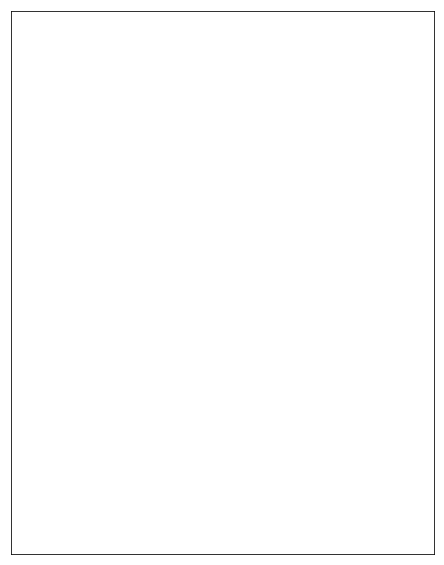

In [12]:
#Map creation

shp = fiona.open('data/city.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

m = Basemap(
    projection='tmerc',
    lon_0=18,
    lat_0=50.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - 2*extra * w,
    llcrnrlat=coords[1] - 2*extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    'data/city',
    'rybnik',
    color='none',
    zorder=2)


In [13]:
#Map dataframe set up
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.rybnik],
    'district': [ward['name'] for ward in m.rybnik_info],
    'id': [ward['id'] for ward in m.rybnik_info]})

df_map = df_map.sort_values('district')
df_map.set_index('id',inplace=True)

#It contains current data for every sensor
df_map = df_map.join(sensors, how='inner', lsuffix='sens').join(currentData, how='inner', rsuffix='current')
df_map = df_map.reset_index()


#Create Point objects in map coordinates from dataframe lon and lat values
map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(sensors['longitude'], sensors['latitude'])])
plaque_points = MultiPoint(list(map_points.values))
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
ldn_points = filter(wards_polygon.contains, plaque_points)

df_map['count'] = df_map['poly'].map(lambda x: int(len(filter(prep(x).contains, ldn_points))))


In [14]:
df_map

,id,district,poly,displayAddress1,displayAddress2,latitude,longitude,HUMIDITY,PM1,PM10,PM25,PRESSURE,TEMPERATURE,count
0,7431,Boguszowice Osiedle,"POLYGON ((10315.74121566391 4191.036626163715,...","Rybnik, Boguszowice Osiedle","ZSP 8, J. Lompy 6",50.045437,18.608738,57.25,3.28,6.45,4.56,1007.44,19.13,1
1,2324,Boguszowice Stare,"POLYGON ((12378.64357142212 3990.647439879765,...","Rybnik, Boguszowice Stare","ZSP 6, S. Małachowskiego 44",50.061119,18.599268,57.17,1.45,2.63,1.91,1008.66,17.88,1
2,2095,Chwałowice,"POLYGON ((7255.384606315161 4685.660155341099,...","Rybnik, Chwałowice","LO 4, J. 1 Maja 91a",50.069202,18.548222,60.97,1.39,2.74,1.95,1008.62,18.44,1
3,2083,Chwałęcice,"POLYGON ((4897.596176724594 13947.57826467591,...","Rybnik, Chwałęcice","ZSP 15, Gzelska 7",50.133137,18.485428,68.73,1.57,3.04,2.15,1007.96,17.63,1
4,2174,Golejów,"POLYGON ((7279.166916843114 13021.97566730822,...","Rybnik, Golejów","ZSP 4, Komisji Edukacji Narodowej 29",50.143864,18.540533,60.67,1.00,2.30,1.44,1008.10,18.12,1
5,2297,Gotartowice,"POLYGON ((12550.67448483729 7956.422056038364,...","Rybnik, Gotartowice","P 22, Gotartowicka 24",50.075142,18.615944,61.30,1.79,3.25,2.29,1008.94,18.55,1
6,2359,Grabownia,"POLYGON ((7256.455710814833 13014.81216176864,...","Rybnik, Grabownia","OSP, W. Poloczka 76c",50.140671,18.523371,64.58,1.24,2.09,1.59,1007.92,18.42,1
7,9829,Kamień,"POLYGON ((9403.582158732595 12910.25350248865,...","Rybnik, Kamień","SP 28, A. Szewczyka 6",50.139717,18.603401,54.34,1.76,4.00,2.77,1007.86,17.87,1
8,2348,Kłokocin,"POLYGON ((12347.29882492916 4584.142389537404,...","Rybnik, Kłokocin","SP 19, Włościańska 39e",50.054829,18.626314,53.79,1.50,2.71,1.99,1007.84,18.35,1
9,9004,Ligota-Ligocka Kuźnia,"POLYGON ((11428.63542915496 9043.03113843173, ...","Rybnik, Ligota-Ligocka Kuźnia","SP 4, K. Miarki 74",50.089809,18.578859,56.10,1.27,2.75,1.88,1008.02,18.52,1


In [15]:
other_cities = currentData[['PM10']].query('id not in @sensors.index').reset_index()
other_cities['Miasto'] = other_cities.id.apply(lambda x: "Wrocław" if x==1127 else ("Kraków" if x==820 else ("Warszawa" if x==337 else ("Gdańsk" if x == 3432 else ""))))
other_cities.rename(index=str, columns={"PM10": "PM 10"}, inplace=True)
other_cities = other_cities.round(1).sort_values(by="PM 10", ascending = False)

<Figure size 1008x720 with 0 Axes>

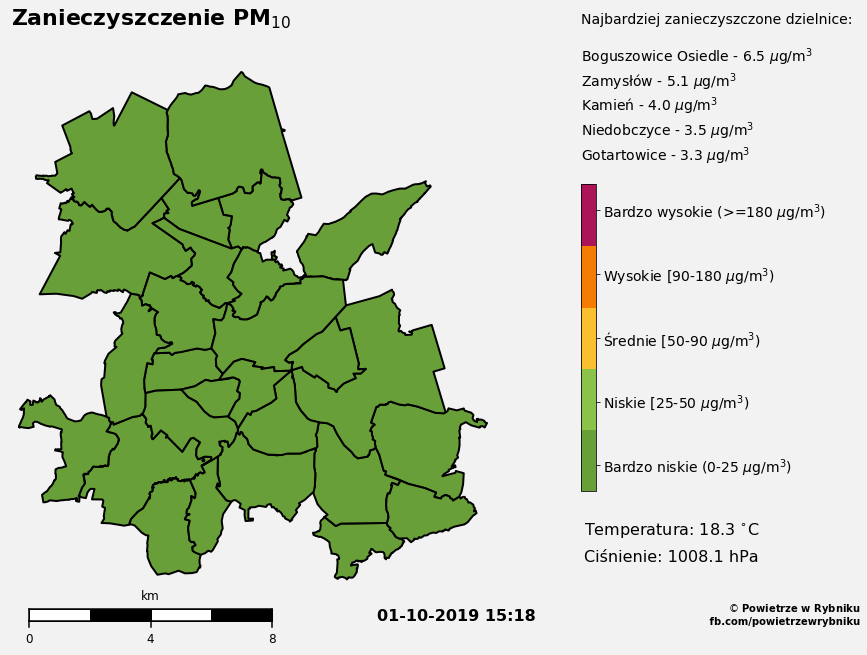

In [17]:
#Create a map with current measurements for PM10 Index

pm10_labels = ['Bardzo niskie (0-25 $\mu$g/m$^3$)',
 'Niskie [25-50 $\mu$g/m$^3$)',
 'Średnie [50-90 $\mu$g/m$^3$)',
 'Wysokie [90-180 $\mu$g/m$^3$)',
    'Bardzo wysokie (>=180 $\mu$g/m$^3$)']

for i, text in enumerate(pm10_labels):
    pm10_labels[i] = text.decode('utf-8')
    
cmap = colors.ListedColormap(['#689f38','#8bc34a','#fbc02d','#f57c00','#ad1457'])
bounds= [0,25,50,90,180,1000]
norm = colors.BoundaryNorm(bounds, cmap.N)


plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w', frame_on=False)
fig.patch.set_facecolor('#f2f2f2')


# draw wards with black outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#000000', lw=2., alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)

pc.set_facecolor(cmap(norm(df_map['PM10'].values)))
ax.add_collection(pc)


# Add a colour bar
cb = colorbar_index(ncolors=len(pm10_labels), cmap=cmap, shrink=0.5, labels=pm10_labels)
cb.ax.tick_params(labelsize=14)


# Show highest densities, in descending order
highest = '\n'.join(
    value[1] + " - " + str(round(value['PM10'],1)) + " $\mu$g/m$^3$" for _, value in df_map.sort_values(by='PM10', ascending=False)[:5].iterrows())#.decode('utf-8')


highest = 'Najbardziej zanieczyszczone dzielnice:\n\n' + highest
# Subtraction is necessary for precise y coordinate alignment
details = cb.ax.text(
    0., 1.55,
    highest,
    ha='left', va='top',
    size=14,
    color='#000000')

# Show current date-hour
date = ax.text(
    1.10, 0.033,
    current_time,
    ha='right', va='bottom',  weight = 'bold',
    size=16,
    color='#000000',
transform=ax.transAxes)


# # Show current temperature
tmpr = ax.text(
    1.2, 0.170,
    "Temperatura: %s $^{\circ}$C" %round(df_map['TEMPERATURE'].mean(),1),
    ha='left', va='bottom', 
    size=16,
    color='#000000',
transform=ax.transAxes)

# Show current pressure
prsr = ax.text(
    1.2, 0.130,
    u"Ciśnienie: %s hPa" %round(df_map['PRESSURE'].mean(),1),
    ha='left', va='bottom', 
    size=16,
    color='#000000',
transform=ax.transAxes)


# Bin method, copyright and source data info
smallprint = cb.ax.text(
    1.78, 0.028,
    '$\copyright$ Powietrze w Rybniku\n fb.com/powietrzewrybniku'.decode('utf-8'),
    ha='right', va='bottom',
    size=10,
    weight = 'bold',
    color='#000000',
    transform=ax.transAxes)


# Draw a map scale
m.drawmapscale(
    coords[0] + 0.06, coords[1] - 0.01,
    coords[0], coords[1], 
    8.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#000000',
    fontcolor='#000000', fontsize=12,
    zorder=5)

#Title
plt.title("Zanieczyszczenie PM$_{10}$".decode('utf-8'), fontsize=22, loc='left', weight='bold')


#Save the file
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.1)
fig.set_size_inches(12, 10)
plt.savefig('pictures/cur_pm10_%s.png'%current_time_to_file, dpi=200, alpha=True, bbox_inches='tight')
#plt.show()

In [19]:
# # Generating message

message_other_cities = "Zanieczyszczenie PM 10, " + current_time +". W innych miastach Polski zanieczyszczenie wynosi: \n"
for index, row in other_cities.iterrows():
    message_other_cities = message_other_cities + row['Miasto'] + " - " +  str(row['PM 10']) + " ug/m3 (" +str(int(2*row['PM 10'])) + " %) \n"

message_other_cities = message_other_cities + "\nRybnik - dzielnica po dzielnicy: \n\n"    
message_other_cities = message_other_cities.decode('utf-8')

print_pm10 = df_map[['PM10','district']]
#print_pm10['district'] = print_pm10['district'].apply(lambda x: x.decode('utf-8'))
print_pm10.rename(index=str, columns={"district": "Dzielnica", "PM10": "PM 10"}, inplace=True)
print_pm10.sort_values(by='PM 10', ascending=False, inplace=True)
print_pm10["PM 10"] = print_pm10["PM 10"].round(1).apply(lambda x: str(x) + " ug/m3 (" +str(int(2*x)) + " %)")
print_pm10.reset_index(drop=True, inplace=True)


message_ = tabulate(print_pm10.set_index("PM 10"), headers='keys',tablefmt= 'simple')

message_to_print = message_other_cities + message_

/Users/opera_user/.local/share/virtualenvs/projekt-p-UQ4WhQYO/lib/python2.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/opera_user/.local/share/virtualenvs/projekt-p-UQ4WhQYO/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/opera_user/.local/share/virtualenvs/projekt-p-UQ4WhQYO/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [21]:
print(message_to_print)

Zanieczyszczenie PM 10, 01-10-2019 15:18. W innych miastach Polski zanieczyszczenie wynosi: 
Gdańsk - 4.8 ug/m3 (9 %) 
Kraków - 4.2 ug/m3 (8 %) 

Rybnik - dzielnica po dzielnicy: 

PM 10             Dzielnica
----------------  ---------------------
6.4 ug/m3 (12 %)  Boguszowice Osiedle
5.1 ug/m3 (10 %)  Zamysłów
4.0 ug/m3 (8 %)   Kamień
3.5 ug/m3 (7 %)   Niedobczyce
3.2 ug/m3 (6 %)   Gotartowice
3.1 ug/m3 (6 %)   Maroko-Nowiny
3.1 ug/m3 (6 %)   Rybnicka Kuźnia
3.1 ug/m3 (6 %)   Popielów
3.0 ug/m3 (6 %)   Wielopole
3.0 ug/m3 (6 %)   Chwałęcice
3.0 ug/m3 (6 %)   Śródmieście
2.9 ug/m3 (5 %)   Zebrzydowice
2.9 ug/m3 (5 %)   Radziejów
2.9 ug/m3 (5 %)   Paruszowiec-Piaski
2.9 ug/m3 (5 %)   Niewiadom
2.8 ug/m3 (5 %)   Ligota-Ligocka Kuźnia
2.7 ug/m3 (5 %)   Chwałowice
2.7 ug/m3 (5 %)   Kłokocin
2.7 ug/m3 (5 %)   Rybnik-Północ
2.6 ug/m3 (5 %)   Boguszowice Stare
2.4 ug/m3 (4 %)   Ochojec
2.3 ug/m3 (4 %)   Golejów
2.3 ug/m3 (4 %)   Meksyk
2.1 ug/m3 (4 %)   Orzepowice
2.1 ug/m3 (4 %)   Grabownia